In [2]:
import pandas as pd


In [3]:
df_review = pd.read_csv("../Data/IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df_positive = df_review[df_review['sentiment'] == 'positive'][:9000]
df_negative = df_review[df_review['sentiment'] == 'negative'][:1000]

In [6]:
df_review_imb = pd.concat([df_positive, df_negative])

In [7]:
import seaborn as sns

<AxesSubplot:xlabel='sentiment', ylabel='count'>

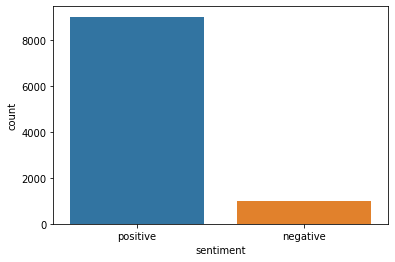

In [8]:
sns.countplot(x='sentiment', data = df_review_imb)

In [9]:
from imblearn.under_sampling import RandomUnderSampler

In [10]:
rus = RandomUnderSampler(random_state= 0)
df_review_bal, df_review_bal['sentiment'] = rus.fit_resample(df_review_imb[['review']], df_review_imb['sentiment'])

In [11]:
df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

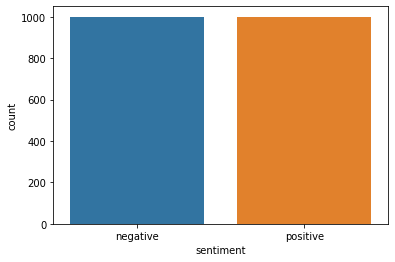

In [12]:
sns.countplot(x='sentiment', data = df_review_bal)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train, test = train_test_split(df_review_bal, test_size=0.33, random_state=42)

In [15]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
tfidf = TfidfVectorizer(stop_words='english')

In [18]:
train_x_vector = tfidf.fit_transform(train_x)
train_x_vector

<1340x20625 sparse matrix of type '<class 'numpy.float64'>'
	with 118834 stored elements in Compressed Sparse Row format>

In [20]:
matrix_df = pd.DataFrame.sparse.from_spmatrix(train_x_vector,
index = train_x.index, columns = tfidf.get_feature_names_out())

In [27]:
test_x_vector = tfidf.transform(test_x)

SVC

In [28]:
from sklearn.svm import SVC

In [29]:
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

Testing Prediction

In [32]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all'])))
print(svc.predict(tfidf.transform(['This movie sucks'])))
print(svc.predict(tfidf.transform(['This movie rules'])))

['positive']
['positive']
['negative']
['negative']
['positive']


Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

DecisionTreeClassifier()

Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB

In [36]:
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()

Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
log_reg = LogisticRegression()
log_reg.fit(train_x_vector, train_y)

LogisticRegression()

Mean Accuracy of every model

In [40]:
print("SVM: ",svc.score(test_x_vector, test_y))
print("Decision Tree: ",dec_tree.score(test_x_vector, test_y))
print("Naive Bayes: ",gnb.score(test_x_vector.toarray(), test_y))
print("Logistic Regression",log_reg.score(test_x_vector, test_y))

SVM:  0.8409090909090909
Decision Tree:  0.6651515151515152
Naive Bayes:  0.6348484848484849
Logistic Regression 0.8303030303030303


F1 Score

F1 Score is the weighted average of Precision and Recall. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. Also, F1 takes into account how the data is distributed, so it’s useful when you have data with imbalance classes.

F1 score is calculated with the following formula. (If you don’t know what precision and recall means, check this great explanation on https://stackoverflow.com/questions/14117997/what-does-recall-mean-in-machine-learning)

In [41]:
from sklearn.metrics import f1_score

In [42]:
f1_score(test_y, svc.predict(test_x_vector), 
labels=['positive', 'negative'], average=None)

array([0.84671533, 0.83464567])

Classification report

We can also build a text report showing the main classification metrics that include those calculated before. To obtain the classification report, we need the true labels and predicted labels classification_report(y_true, y_pred)

In [43]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(test_y,
svc.predict(test_x_vector), 
labels=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
conf_mat = confusion_matrix(test_y,
svc.predict(test_x_vector), 
labels=['positive','negative'])

In [47]:
print(conf_mat)

[[290  45]
 [ 60 265]]


GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
#Set Parameters
parameters = {'C':[1,4,8,16,32], 'kernel':['linear','rbf']}

In [50]:
svc2 = SVC()
svc_grid = GridSearchCV(svc2, parameters, cv=5)
svc_grid.fit(train_x_vector, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

In [51]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')
